An Independent Medical Review (IMR) is a process in which expert independent medical professionals are selected to review specific medical decisions made by the insurance company. The California Department of Insurance (CDI) administers an Independent Medical Review program that enables the insured to request an impartial appraisal of medical decisions within certain guidelines as specified by the law. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

from dash import dcc
from phik import phik_matrix
from seaborn import heatmap, set_theme
import plotly.subplots as sp
from plotly.subplots import make_subplots
from wordcloud import WordCloud

In [3]:
# read the csv file dataframe
df = pd.read_csv(r"C:\Users\marwafathin\Documents\IMR Request California\IMR California\Independent_Medical_Review__IMR__Determinations__Trend.csv")
df.head()

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
0,MN16-22639,2016,Infectious,Hepatitis,Pharmacy/Prescription Drugs,Anti-virals,Overturned Decision of Health Plan,Medical Necessity,41-50,Male,Nature of Statutory Criteria/Case Summary: An ...
1,MN16-22638,2016,Mental,Eating Disorder,Mental Health Treatment,Residential Treatment Center - Admission,Upheld Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...
2,MN16-22637,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Female,Nature of Statutory Criteria/Case Summary: Th...
3,EI16-22636,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An ...
4,EI06-5319,2006,Cardiac/Circulatory,NaN,Cardio Vascular,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,Physician 1: The patient is a 62-year-old male...


# **DATA PREPROCESSING**

In [4]:
# Checking types data
df.info(), df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reference ID            19245 non-null  object
 1   Report Year             19245 non-null  int64 
 2   Diagnosis Category      19186 non-null  object
 3   Diagnosis Sub Category  17341 non-null  object
 4   Treatment Category      18795 non-null  object
 5   Treatment Sub Category  17977 non-null  object
 6   Determination           19245 non-null  object
 7   Type                    19245 non-null  object
 8   Age Range               18035 non-null  object
 9   Patient Gender          18035 non-null  object
 10  Findings                19225 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.6+ MB


(None,
 Reference ID              object
 Report Year                int64
 Diagnosis Category        object
 Diagnosis Sub Category    object
 Treatment Category        object
 Treatment Sub Category    object
 Determination             object
 Type                      object
 Age Range                 object
 Patient Gender            object
 Findings                  object
 dtype: object)

**DEALING WITH MISSING VALUE**

In [5]:
# check missing value
imr_total = len(df)
missing_value = df.isnull().sum().reset_index(name='count')
missing_value['Percentage'] = missing_value['count'] / imr_total * 100
missing_value.columns = ['column', 'count', 'percentage']
missing_value

,column,count,percentage
0,Reference ID,0,0.000000
1,Report Year,0,0.000000
2,Diagnosis Category,59,0.306573
3,Diagnosis Sub Category,1904,9.893479
4,Treatment Category,450,2.338270
5,Treatment Sub Category,1268,6.588724
6,Determination,0,0.000000
7,Type,0,0.000000
8,Age Range,1210,6.287347
9,Patient Gender,1210,6.287347


Question: Why Patient Gender and Age Range column has same number of missing value?

In [6]:
# Finding out on which year missing value of Patient Gender column are
Years_Missing = np.sort(df[df['Patient Gender'].isnull()]['Report Year'].unique())
Years_Missing

array([2001, 2002, 2003], dtype=int64)

In [7]:
# Finding out on which year missing value of Age Range column are
Years_Missing_Age = np.sort(df[df['Age Range'].isnull()]['Report Year'].unique())
Years_Missing_Age

array([2001, 2002, 2003], dtype=int64)

Answer: Patient Gender and Age Range have missing value on 2001, 2002 and 2003 because there is different technique of data input on those years but we can extract information about Patient Gender and Age Range from Findings column

In [8]:
import re

# Extract Patient Gender information from Findings column
def extracted_gender(row):
    gender = None
    if row['Patient Gender'] in ['Male', 'Female']:
        gender = row['Patient Gender']
    elif str(row['Patient Gender']).lower() == "nan" or str(row['Patient Gender']).lower() == "none":
        first_20_words = row['Findings'].split(' ')[:20]
        if any(re.search(r'\b(?:his|male|man)\b', word) for word in first_20_words):
            gender = 'Male'
        if any(re.search(r'\b(?:her|female|woman)\b', word) for word in first_20_words):
            gender = 'Female'
    return gender

In [9]:
# Ekstract Age Range information from Findings column
def extracted_age(row):
    if isinstance(row['Findings'], str):
        first_20_words = row['Findings'].split(' ')[:20]
        for word in first_20_words:
            temp_age = re.search(r'(\d{1,3})[\- ]year', word, re.IGNORECASE)
            if temp_age is not None:
                return int(temp_age.group(1))
    return np.nan
                
# Calculate the age range
def calculate_age_range(row):
    # Use the extracted age that was extracted from Findings column to repopulated the missing values in Age Range column
    age_range = row["Age Range"]
    extracted_age = row["Extracted Age"]
    if age_range != str:
        if 0 <= extracted_age <= 10:
            age_range = "0-10"
        elif 11 <= extracted_age <= 20:
            age_range = "11-20"
        elif 21 <= extracted_age <= 30:
            age_range = "21-30"
        elif 31 <= extracted_age <= 40:
            age_range = "31-40"
        elif 41 <= extracted_age <= 50:
            age_range = "41-50"
        elif 51 <= extracted_age <= 64:
            age_range = "51-64"
        elif extracted_age >= 65:
            age_range = "65+"
    return age_range

# Fix age range typo
def fix_age_range_typo(row):
    age_range = row['Age Range']
    if age_range == "11_20":
        age_range = "11-20"
    return age_range

In [10]:
# Extract gender and age value to new column
df['Extracted Gender'] = df.apply(extracted_gender, axis=1)
df['Extracted Age'] = df.apply(extracted_age, axis=1)

# Recalculate original age range column's NaN values from new Extracted Age
df['Age Range'] = df.apply(calculate_age_range, axis=1)

# Fix a typo in the "11-20" age range category
df["Age Range"] = df.apply(fix_age_range_typo, axis=1)

# Extract gender to Patient Gender column
df['Patient Gender'] = df.apply(extracted_gender, axis=1)

We success extracting Patient Gender information from Findings column even though there are still three missing values. We success reducing missing values from 1210 to 3 missing values

In [11]:
df['Patient Gender'].value_counts(dropna=False)

Female    11137
Male       8105
None          3
Name: Patient Gender, dtype: int64

On the other hand, we success reducing 1210 missing values in Age Range column to 72 missing values.

In [12]:
df['Age Range'].value_counts(dropna=False)

51-64    6986
41-50    3841
31-40    2280
11-20    1968
0-10     1829
21-30    1535
65+       734
NaN        72
Name: Age Range, dtype: int64

In [13]:
# Replace the NaN values with Unknown
df[['Diagnosis Sub Category', 'Treatment Sub Category']] = df[['Diagnosis Sub Category', 'Treatment Sub Category']].fillna('Unknown')

df[['Diagnosis Category', 'Treatment Category']] = df[['Diagnosis Category', 'Treatment Category']].fillna('Unknown')

df['Patient Gender'] = df['Patient Gender'].fillna('Unknown')

**DEALING WITH DUPLICATE DATA**

In [ ]:
duplicate = df.duplicated()

if duplicate.any():
    print("There is duplicate data")
else:
    print("There is no duplicate data")

In [15]:
# Make sure there is no duplicate data
duplicated = pd.DataFrame(df.loc[df.duplicated()].count())
duplicated.columns = ['Total Duplicated']
duplicated

,Total Duplicated
Reference ID,0
Report Year,0
Diagnosis Category,0
Diagnosis Sub Category,0
Treatment Category,0
Treatment Sub Category,0
Determination,0
Type,0
Age Range,0
Patient Gender,0


# **DATA OBSERVATION**

With this IMR Request dataframe, I only focus on Patient Gender, Age Range, Diagnosis and Treatment column observation. I use plotly to visualize the data because it makes the visualization looks so interactive.

Over the years the most frequently asked for IMR request was patient in age range 51-64, patient with female gender, and patient who needed medical necessity. Using plotly, number and percentage of IMR Request can showed in every year.

In [16]:
year_age_range = df.groupby(['Report Year', 'Age Range']).size().reset_index(name='Number of IMR Request')
year_age_range.columns = ['Report Year', 'Category', 'Number of IMR Request']

year_patient_gender = df.groupby(['Report Year', 'Patient Gender']).size().reset_index(name='Number of IMR Request')
year_patient_gender.columns = ['Report Year', 'Category', 'Number of IMR Request']

year_type = df.groupby(['Report Year', 'Type']).size().reset_index(name='Number of IMR Request')
year_type.columns = ['Report Year', 'Category', 'Number of IMR Request']

In [17]:
def categories(dataframe, title):
    grouped = dataframe.groupby(['Report Year', 'Category'])['Number of IMR Request'].sum().reset_index()

    total_request = grouped['Number of IMR Request'].sum()
    grouped['Percent'] = grouped['Number of IMR Request'] / total_request * 100
    grouped['Percent'] = grouped['Percent'].apply(lambda x: f'{x:.2f}%')

    hover_data = {
        'Report Year': True,
        'Number of IMR Request': True,
        'Category': True,
        'Percent': True
    }

    fig = px.line(grouped, x='Report Year', y='Number of IMR Request', color='Category', hover_data=hover_data, markers=True)
    fig.update_layout(title=title)

    return fig

dataframes = [year_age_range, year_patient_gender, year_type]
titles = ['IMR Request by Age Range', 'IMR Request by Patient Gender', 'IMR Request by Type']

figures = []

for dataframe, title in zip(dataframes, titles):
    fig = categories(dataframe, title)
    figures.append(fig)

for fig in figures:
    fig.show()


Based on graph above, number of IMR request has the most frequently request in 2015

Question: What happen in 2015?

In [18]:
diagnosis_count_by_year = df.groupby('Report Year')['Diagnosis Category'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Diagnosis Category')
max_diagnosis_count = df.groupby(['Report Year', 'Diagnosis Category']).size().groupby('Report Year').max().reset_index(name='Diagnosis Count')

# Merge the column
diagnosis_count_by_year = diagnosis_count_by_year.merge(max_diagnosis_count, on='Report Year')

# Sort the data by "Report Year"
diagnosis_count_by_year = diagnosis_count_by_year.sort_values('Report Year')
diagnosis_count_by_year

,Report Year,Diagnosis Category,Diagnosis Count
0,2001,Orthopedic/ Musculoskeletal,122
1,2002,Orthopedic/ Musculoskeletal,123
2,2003,Orthopedic/ Musculoskeletal,130
3,2004,Orthopedic/ Musculoskeletal,118
4,2005,Orthopedic/ Musculoskeletal,192
5,2006,Orthopedic/ Musculoskeletal,213
6,2007,Orthopedic/ Musculoskeletal,269
7,2008,Orthopedic/ Musculoskeletal,291
8,2009,Orthopedic/ Musculoskeletal,294
9,2010,Orthopedic/ Musculoskeletal,252


Answer: Based on source I attached below, on December 2014-Februari 2015 there was measles outbreak in California. Maybe this outbreak is the one of many reasons IMR has the most frequently requested.

source: https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6406a5.htm

Patient with diagnosis category Orthopedic was the most frequently request for IMR in 2001 until 2013. In 2014 the most requested IMR comes from patient with diagnosis category Mental. On the other hand, in 2015 until 2016, patient with diagnosis category Infectious requested IMR the most.

In [19]:
# Visulize the data with pie chart
fig = px.pie(diagnosis_count_by_year, values='Diagnosis Count', names='Diagnosis Category', title='Diagnosis Count by Year')

fig.update_traces(textposition='inside', textinfo='percent', hovertemplate='Year: %{customdata}')
fig.update_traces(customdata=diagnosis_count_by_year['Report Year'])

fig.show()

Compared to Diagnosis Category column, Diagnosis Sub Category column contain many uncertainity diagnosis. Many of them just listed as 'Other'. But in 2016 Hepatitis was the sub diagnosis that got most of IMR requested.

In [20]:
subdiag_by_year = df.groupby('Report Year')['Diagnosis Sub Category'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Sub Diagnosis Category')
max_subdiag_count = df.groupby(['Report Year', 'Diagnosis Sub Category']).size().groupby('Report Year').max().reset_index(name='Sub Diagnosis Count')

# Merge the column
subdiag_by_year = subdiag_by_year.merge(max_subdiag_count, on='Report Year')

# Sort the data by "Report Year"
subdiag_by_year = subdiag_by_year.sort_values('Report Year')
subdiag_by_year

,Report Year,Sub Diagnosis Category,Sub Diagnosis Count
0,2001,Other,152
1,2002,Other,287
2,2003,Other,160
3,2004,Other,195
4,2005,Other,198
5,2006,Other,190
6,2007,Other,235
7,2008,Other,346
8,2009,Other,265
9,2010,Unknown,257


Both female and male patient request IMR mostly when they got Orthopedic/Muculoskeletal Diagnosis Category and second most was Mental Diagnosis Category

In [21]:
#Calculate Diagnosis Category by Patient Gender
imr_total = len(df)
    
diagnosis_count = df[df['Patient Gender']=="Female"]['Diagnosis Category'].value_counts().reset_index(name='Female Count')
diagnosis_count['Female Percent'] = diagnosis_count['Female Count']/imr_total * 100
    
male_diagnosis_count = df[df['Patient Gender'] == "Male"]['Diagnosis Category'].value_counts().reset_index(name='Male Count')
male_diagnosis_count['Male Percent'] = male_diagnosis_count['Male Count']/imr_total * 100

diagnosis_count = diagnosis_count.merge(male_diagnosis_count)
diagnosis_count = diagnosis_count.rename(columns={'index': 'Diagnosis Category'})
    
diagnosis_count = diagnosis_count.head(10)

fig = px.bar(diagnosis_count, x=['Female Count', 'Male Count'], y='Diagnosis Category', orientation='h', text_auto=True)
fig.update_layout(title_text="Diagnosis Count by Patient Gender")
fig.show()

Compared to Diagnosis Category column, many both of female and male patient were listed as 'Other' and 'Unknown' in Diagnosis Sub Category column. If we set aside the 'Unknown' and 'Others' value, we can see most of female patient request an IMR when they got diagnosis Back Pain and Breat Cancer. On the other hand, most of male patient request an IMR when they got diagnosis Back Pain and Hepatitis.

In [22]:
#Calculate Diagnosis Sub Category by Patient Gender
imr_total = len(df)
    
subdiag_count = df[df['Patient Gender']=="Female"]['Diagnosis Sub Category'].value_counts().reset_index(name='Female Count')
subdiag_count['Female Percent'] = subdiag_count['Female Count']/imr_total * 100
    
male_subdiag_count = df[df['Patient Gender'] == "Male"]['Diagnosis Sub Category'].value_counts().reset_index(name='Male Count')
male_subdiag_count['Male Percent'] = male_subdiag_count['Male Count']/imr_total * 100

subdiag_count = subdiag_count.merge(male_subdiag_count)
subdiag_count = subdiag_count.rename(columns={'index': 'Diagnosis Category'})
    
subdiag_count = subdiag_count.head(10)
subdiag_count

,Diagnosis Category,Female Count,Female Percent,Male Count,Male Percent
0,Other,2399,12.465575,1592,8.272279
1,Unknown,1293,6.718628,611,3.174851
2,Back Pain,427,2.218758,261,1.356196
3,Breast Cancer,400,2.078462,4,0.020785
4,Hepatitis,336,1.745908,455,2.364250
5,Eating Disorder,290,1.506885,15,0.077942
6,Female Breast Disorder,273,1.418550,1,0.005196
7,Vertebral Disc Problem,248,1.288646,229,1.189919
8,Depression - Severe,205,1.065212,88,0.457262
9,Osteoarthritis,204,1.060016,142,0.737854


There is an issue. One male gender patient got Diagnosis Category OB-Gyn/Pregnancy, but there is no specific reason why this patient was listed under OB-Gyn/Pregnancy since he had breast cancer, he should listed under cancer diagnosis category instead

In [23]:
Male_OBGyn = df.loc[(df['Patient Gender']=='Male') & (df['Diagnosis Category']=='OB-Gyn/ Pregnancy')]['Findings']
print(Male_OBGyn.iloc[0])

Nature of Statutory Criteria/Case Summary: An enrollee has requested breast tomosynthesis for evaluation of his medical condition.   Findings: Two physician reviewers found that the addition of digital breast tomosynthesis reduces false positives and increases cancer detection when compared to two dimensional full field digital mammography alone.  Three dimensional digital breast tomosynthesis allows for separation of structures to differentiate architectural distortion from masses and overlapping fibroglandular tissue.  Given this support, the addition of tomosynthesis to the usual two dimensional protocol was likely of greater benefit to this patient than had the exam been done with two dimensional imaging alone.  Accordingly, breast tomosynthesis  was likely to be more beneficial for evaluation of the patient’s medical condition than any available standard therapy.   Final Result: Two reviewers determined that the services at issue were likely to be more beneficial for evaluation of

In [25]:
# Calculate Diagnosis Category by Age Range
diagnosis_count_by_age = df.groupby('Age Range')['Diagnosis Category'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Diagnosis Category')
max_diagnosis_count_by_age = df.groupby(['Age Range', 'Diagnosis Category']).size().groupby('Age Range').max().reset_index(name='Diagnosis Count')

# Merge the column
diagnosis_count_by_age = diagnosis_count_by_age.merge(max_diagnosis_count_by_age, on='Age Range')

# Sort the data by "Age Range"
diagnosis_count_by_age = diagnosis_count_by_age.sort_values('Age Range')
diagnosis_count_by_age

,Age Range,Diagnosis Category,Diagnosis Count
0,0-10,Pediatrics,628
1,11-20,Mental,859
2,21-30,Mental,442
3,31-40,Orthopedic/ Musculoskeletal,437
4,41-50,Orthopedic/ Musculoskeletal,891
5,51-64,Orthopedic/ Musculoskeletal,1529
6,65+,Orthopedic/ Musculoskeletal,175


Most of the time, patient at age range 31-65+ request IMR with diagnosis category Orthopedic/Musculoskeletal. Meanwhile patient at age range 11-30 request IMR with diagnosis category Mental and patient at age range 0-10 request IMR were listed in diagnosis category Pediatrics

In [26]:
# Visulize the data with pie chart
fig = px.pie(diagnosis_count_by_age, values='Diagnosis Count', names='Diagnosis Category', title='Diagnosis Count by Age Range')

fig.update_traces(textposition='inside', textinfo='percent', hovertemplate='Age Range: %{customdata}')
fig.update_traces(customdata=diagnosis_count_by_age['Age Range'])

fig.show()

We found something in this dataframe, most of patient in age range 0-10 years old request an IMR when their diagnosis is Autism-PDD-NOS. Meanwhile others age range showed 'Other' as the most diagnosis sub category that request an IMR. 

In [27]:
# Calculate Diagnosis Sub Category by Age Range
Subdiag_age = df.groupby('Age Range')['Diagnosis Sub Category'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Diagnosis Sub Category')
max_Subdiag_age = df.groupby(['Age Range', 'Diagnosis Sub Category']).size().groupby('Age Range').max().reset_index(name='Diagnosis Count')

# Merge the column
Subdiag_age = Subdiag_age.merge(max_Subdiag_age, on='Age Range')

# Sort the data by "Age Range"
Subdiag_age = Subdiag_age.sort_values('Age Range')
Subdiag_age

,Age Range,Diagnosis Sub Category,Diagnosis Count
0,0-10,Autism-PDD-NOS,353
1,11-20,Other,335
2,21-30,Other,322
3,31-40,Other,545
4,41-50,Other,825
5,51-64,Other,1440
6,65+,Other,155


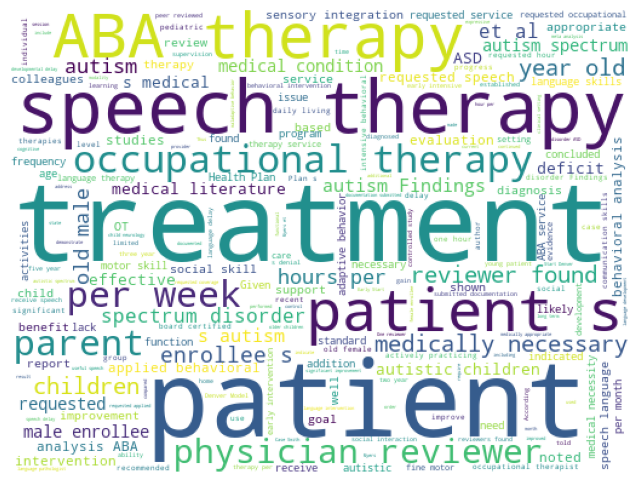

In [28]:
Autism = df.loc[(df['Diagnosis Sub Category'] == 'Autism-PDD-NOS') & (df['Age Range'] == '0-10')]['Findings']

plt.subplots(figsize = (8,8))

wordcloud = WordCloud(background_color = 'white', width = 512, height= 384).generate(' '.join(Autism))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Diagnosis category 'Mental' was treated by Treatment Category 'Mental Treatment', 'Infectious' treated by 'Precription/Drugs', and 'Orthopedic' treated by 'Orthopedic Treatment'

In [29]:
Diagnosis_Treatment = pd.pivot_table(df, index='Diagnosis Category', columns='Treatment Category', aggfunc='size', fill_value=0)

fig = px.imshow(Diagnosis_Treatment, width=1000, height=800, title='Diagnosis and Treatment Frequency')
fig.show()

# **CONCLUSION**

Over the years (2001-2016) the most frequently asked for IMR request was patient in age range 51-64, patient with female gender, and patient who needed medical necessity. Diagnosis category that has most frequently IMR request are Orthopedic/Musculuskeletal and Mental both in patient female and male. On the other hand, IMR Request for diagnosis category mental come from patient in age range 11-30 yo and Orthopedic comes from patient in age range 31-65+